In [1]:
from jax import config
config.update('jax_enable_x64', True)

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from jax import vmap

In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# helpers

In [4]:
def remove_zeros(x, decimals=3):
    """
    Rounds and removes zeros:
    100.0001 -> 100
    1.000001 -> 1
    0.100001 -> 0.1
    """
    x = jnp.round(x, decimals=decimals)
    s = str(x)
    if s[-2:] == '.0': s = s[:-2]
    return s

In [5]:
# helper functions

def map_xy_to_p(xy):
    """
    p1, p2, p3 linearly interpolate between [0, 1] as we move from each vertex to the opposite edge
    this mapping ensures that p1+p2+p3=1 always (inside the traingle)
    """
    x, y = xy
    p1 = y
    p2 = x - 0.5*y
    p3 = 1 - x - 0.5*y
    return jnp.array([p1, p2, p3])

def map_p_to_xy(p):
    y = p[0]
    x = p[1] + 0.5*p[0]
    return jnp.array([x, y])

# test mappings
xy = jnp.array([0.3, 0.4])
assert jnp.allclose(map_p_to_xy(map_xy_to_p(xy)), xy)

def make_grid(s=500):

    # create a grid of (x, y) coordinates
    x = jnp.linspace(0, 1, s)
    y = jnp.linspace(0, 1, s)
    y, x = jnp.meshgrid(x, y)
    xy = jnp.stack([x, y], -1)

    # map each (x, y) to (p1, p2, p3) 
    p = vmap(vmap(map_xy_to_p))(xy)

    # discard negative values (outside of traingle) or tiny values (for numerical stability)
    valid = jnp.all(p > 1e-6, axis=-1) # [s, s]
    p = p.at[~valid].set(0)
    
    return xy, p, valid

In [6]:
def plot_trinagle_axes(ax, tick_size=0.008):
    ax_line_kwargs = dict(c='black', lw=0.5)
    tick_line_kwargs = dict(c='black', lw=0.5)
    
    # remove default square axes
    ax.axis('off')
    
    # bottom axis
    ax.plot((0, 1), (0, 0), **ax_line_kwargs) # axis
    for x0 in jnp.linspace(0, 1, 6):
        y0 = 0
        x1, y1 = x0, y0 - tick_size
        ax.plot((x0, x1), (y0, y1), **tick_line_kwargs) # tick
        ax.text(x1, y1, f'{x0:.1f}', ha='center', va='top', size='small') # label
    ax.text(0.5, -0.05, '$p_C$', size='large', rotation=0, ha='center', va='top')

    # left axis
    ax.plot((0, 0.5), (0, 1), **ax_line_kwargs) # axis
    for y0 in jnp.linspace(0, 1, 6):
        x0 = y0 / 2
        x1, y1 = x0 - tick_size, y0 + tick_size/2
        ax.plot((x0, x1), (y0, y1), **tick_line_kwargs) # tick
        ax.text(x1, y1, f'{1-y0:.1f}', ha='right', va='bottom', size='small') # label
    ax.text(0.2, 0.5, '$p_B$', size='large', rotation=57, ha='right', va='bottom')

    # right axis
    ax.plot((1, 0.5), (0, 1), **ax_line_kwargs) # axis
    for y0 in jnp.linspace(0, 1, 6):
        x0 = 1 - y0 / 2
        x1, y1 = x0 + tick_size, y0 + tick_size/2
        ax.plot((x0, x1), (y0, y1), **tick_line_kwargs) # tick
        ax.text(x1, y1, f'{y0:.1f}', ha='left', va='bottom', size='small') # label
    ax.text(0.8, 0.5, '$p_A$', size='large', rotation=-57, ha='left', va='bottom')
    
    # update axes limits to contain the ticks and tick values
    ax.set_xlim((-0.05, 1.05))
    ax.set_ylim((-0.05, 1.05))

In [7]:
# distributions
def categ_logpdf(p):
    logprobs = jnp.log(p)
    return logprobs[0]

def dir_logpdf(p, alpha_prior, posterior=True, min_logprob=None):
    alpha = jnp.array([alpha_prior, alpha_prior, alpha_prior])
    alpha = alpha.at[0].add(posterior)
    logprobs = jnp.log(p)
    if min_logprob is not None: logprobs = logprobs.clip(min=min_logprob)
    return ((alpha-1)*logprobs).sum()

def dir_gauss_logpdf(p, alpha_prior, posterior=True):
    alpha = alpha_prior * jnp.ones(3)
    alpha = alpha.at[0].add(posterior)
    logprobs = jnp.log(p)
    var = jnp.log(1 / alpha + 1)
    mean = jnp.log(alpha) - var / 2
    mean -= mean.max() # correct for the use of logprobs instead of logits
    log_posterior = (-0.5 * (logprobs - mean)**2 / var).sum()
    return log_posterior

def conf_logpdf(p, rate):
    logprobs = jnp.log(p)
    log_like = logprobs[0]
    log_conf = logprobs.max()
    log_prior = rate * log_conf
    return log_prior + log_like

# dirichlet visualization

-13.73, -4.89
-15.01, -4.20


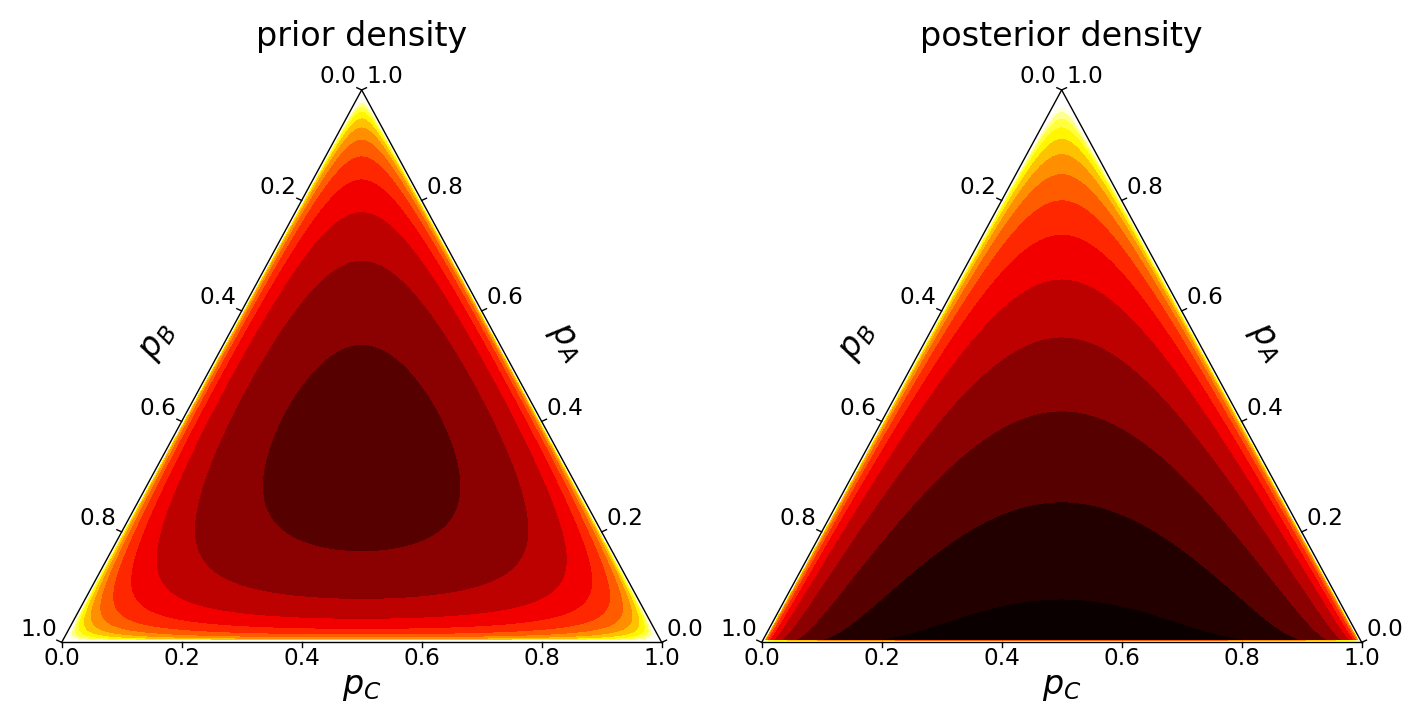

In [8]:
fig, axs = plt.subplots(1, 2, figsize=[7, 3.5], layout='compressed')
alpha_scalar = 0.1

for i, (ax, posterior) in enumerate(zip(axs, [False, True])):
    log_pdf_fn = lambda p: dir_logpdf(p, alpha_scalar, posterior)
    alpha = (alpha_scalar * jnp.ones(3)).at[0].add(posterior)
    
    # joint distribution
    xy, p, valid = make_grid()
    pdf_valid = vmap(log_pdf_fn)(p[valid])
    pdf_valid -= jax.scipy.special.logsumexp(pdf_valid)
    print(f'{pdf_valid.min():=.2f}, {pdf_valid.max():=.2f}')
    img = jnp.zeros(valid.shape).at[valid].set(pdf_valid)
    ax.contourf(img.T, origin='lower', levels=30, extent=[0, 1, 0, 1], vmin=-14.5, vmax=-8, cmap='hot')
    plot_trinagle_axes(ax)
    title = 'posterior density' if posterior else 'prior density'
    ax.set_title(title)
        
plt.savefig('../plots/dirichlet_visualization.pdf')
plt.show()

# dirichlet confidence

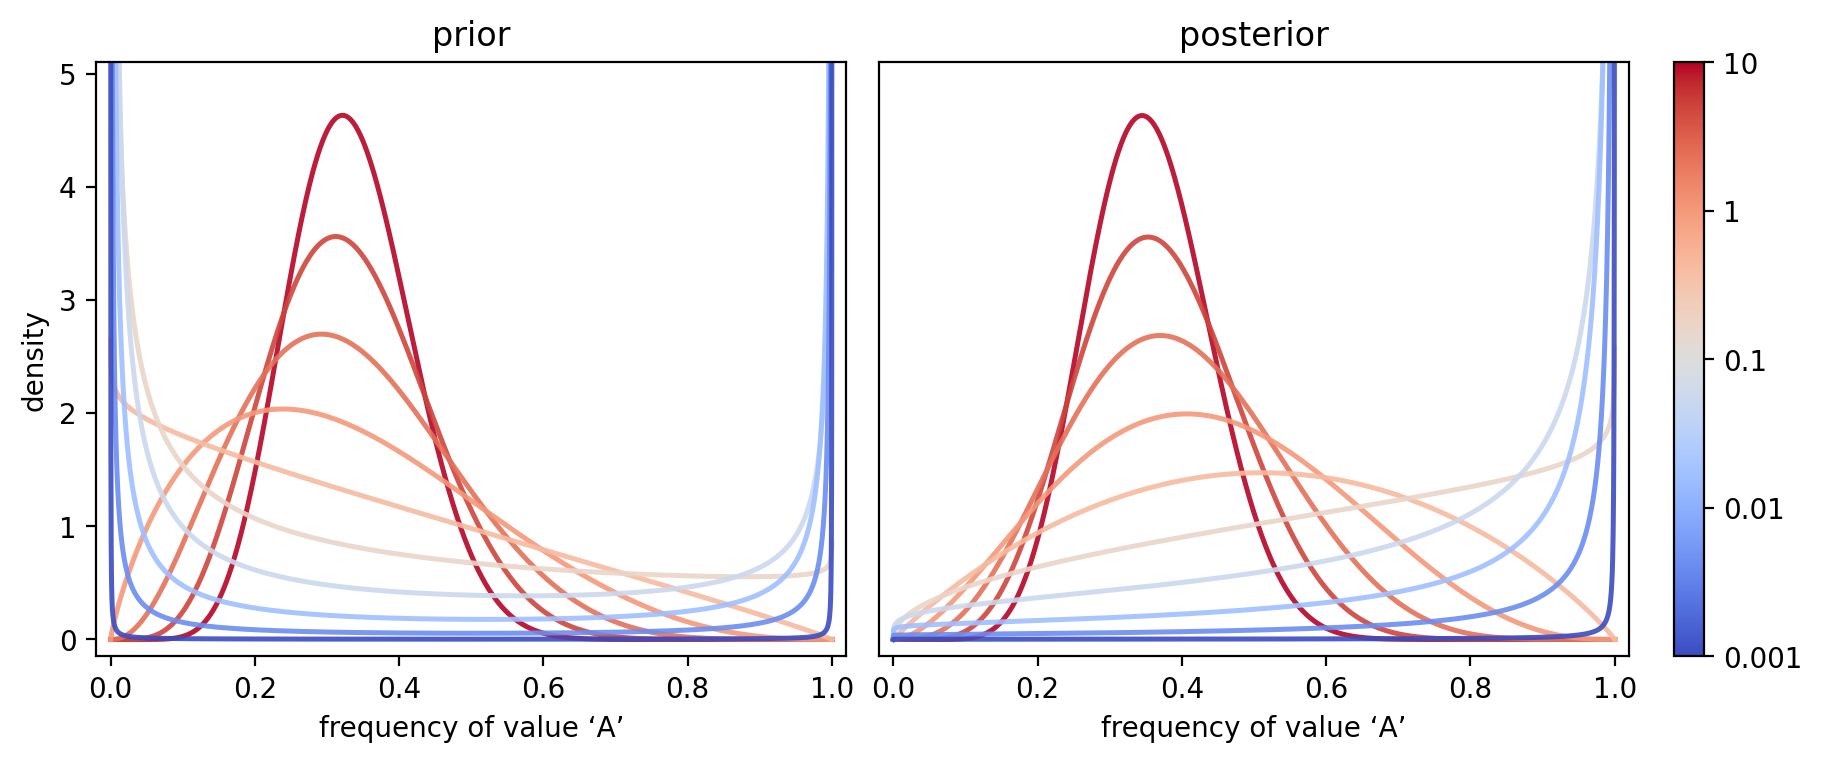

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3.7), layout='compressed')

# sample values of alpha that grow slower than logarithmic - that seems to look the best on the plot
alpha_max = 10
alpha_min = 0.001
multiplier = np.linspace(1, 0, 10)**(0.5)
exps = np.log(alpha_min) + (np.log(alpha_max)-np.log(alpha_min))*multiplier
alphas = np.exp(exps)
color_mapper = mpl.cm.ScalarMappable(cmap='coolwarm')
z = np.log(0.01+alphas) # to better differentiate between cold colors, shift alphas before taking log
colors = color_mapper.to_rgba(z)

x_ = jnp.linspace(0, 1, 10_000)
for i, posterior in enumerate([False, True]):
    for alpha_scalar, color in zip(alphas, colors):
        alpha = (alpha_scalar * jnp.ones(3)).at[0].add(posterior)
        y_ = jax.scipy.stats.beta.pdf(x_, alpha[0], alpha.sum()-alpha[0])
        axs[i].plot(x_, y_, label=f'{alpha=}', c=color, alpha=0.9, lw=1.8)

cbar = fig.colorbar(color_mapper, ax=axs[1])
cbar.set_ticks(ticks=np.linspace(z.min(), z.max(), 5), labels=(0.001, 0.01, 0.1, 1, 10))

axs[0].set_ylabel('density')
axs[0].set_title('prior')
axs[1].set_title('posterior')

for ax in axs:
    ax.set_xlim((-0.02, 1.02))
    ax.set_ylim((-0.15, 5.1))
    ax.set_xticks(jnp.linspace(0, 1, 6))
    ax.set_xlabel("frequency of value ‘A’")

axs[1].tick_params(left=False)
axs[1].set(yticklabels=[])    

plt.savefig('../plots/dirichlet_confidence.pdf')
plt.show()

# likelihood comparison

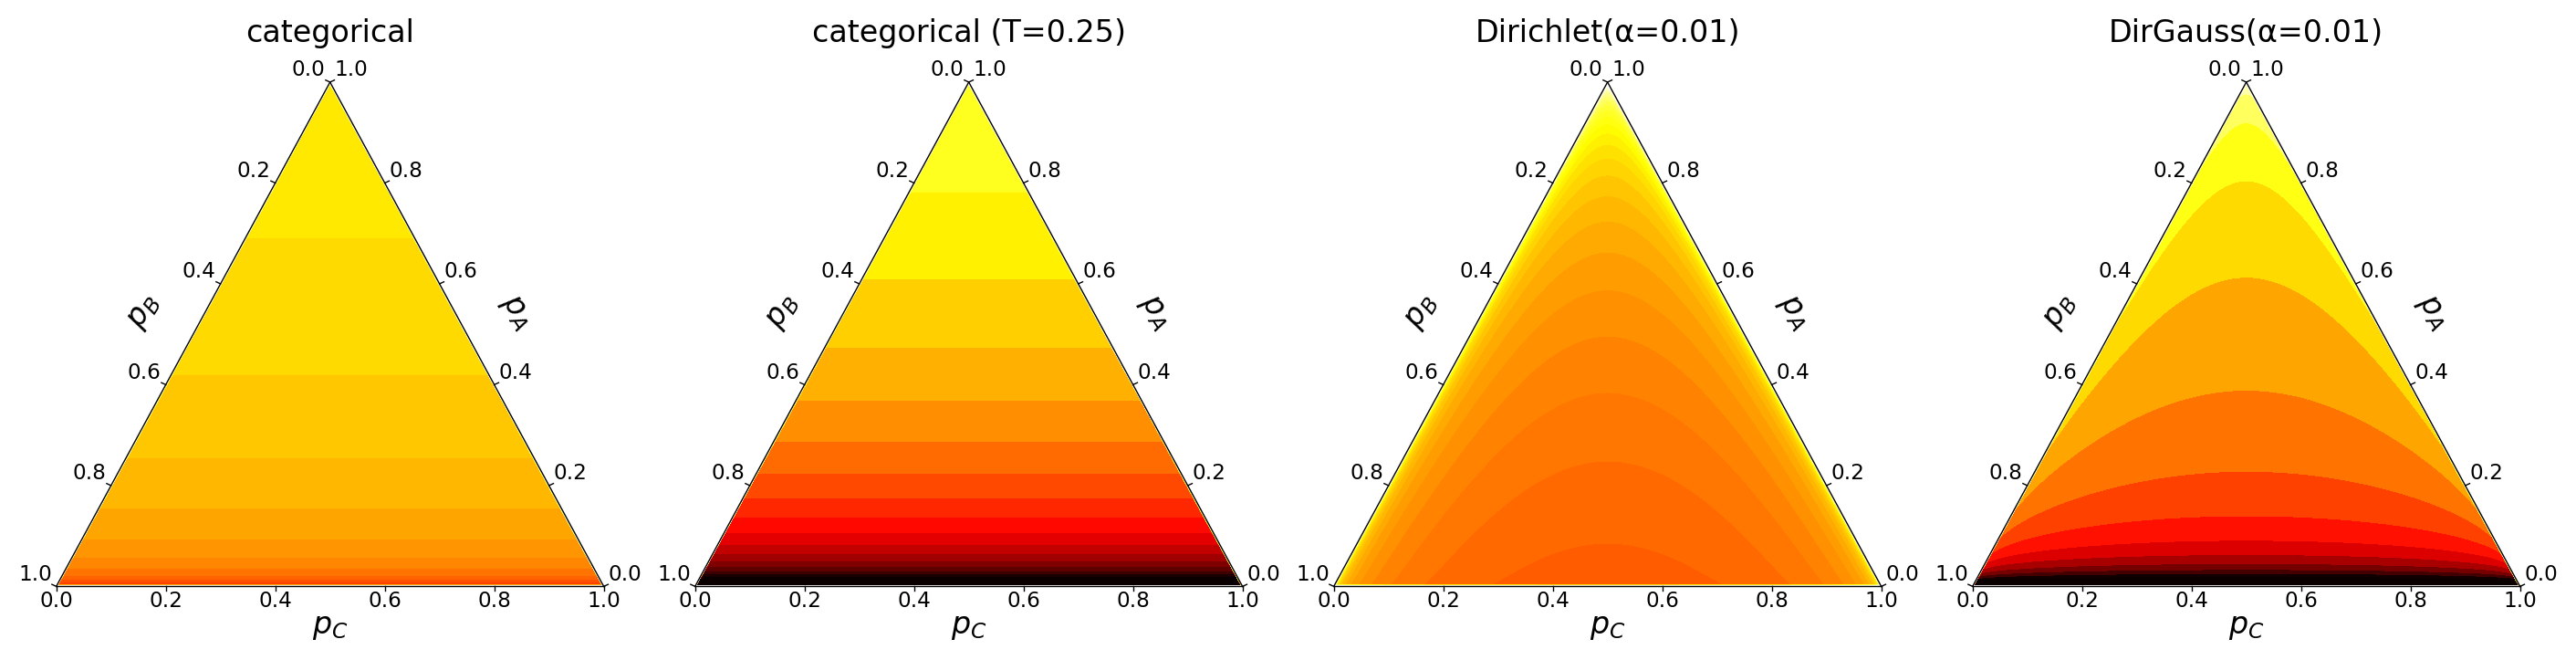

In [10]:
log_pdf_fns = (
    (categ_logpdf, 'categorical'),
    (lambda p: categ_logpdf(p)/0.25, 'categorical (T=0.25)'),
    (lambda p: dir_logpdf(p, 0.01, True), 'Dirichlet(α=0.01)'),
    (lambda p: dir_gauss_logpdf(p, 0.01), 'DirGauss(α=0.01)'),
)

fig, axs = plt.subplots(1, len(log_pdf_fns), figsize=[14, 3.5], layout='compressed')
for ax, (log_pdf_fn, name) in zip(axs.flatten(), log_pdf_fns):
    ax.set_title(name)
    
    # plot pdf
    xy, p, valid = make_grid()
    pdf_valid = vmap(log_pdf_fn)(p[valid])
    pdf_valid -= jax.scipy.special.logsumexp(pdf_valid)
    img = jnp.zeros(valid.shape).at[valid].set(pdf_valid)
    ax.contourf(img.T, origin='lower', levels=40, extent=[0, 1, 0, 1], vmin=-25, vmax=-5, cmap='hot')
    plot_trinagle_axes(ax)

plt.savefig('../plots/likelihood_densities.pdf')
plt.show()

# implied lieklihood

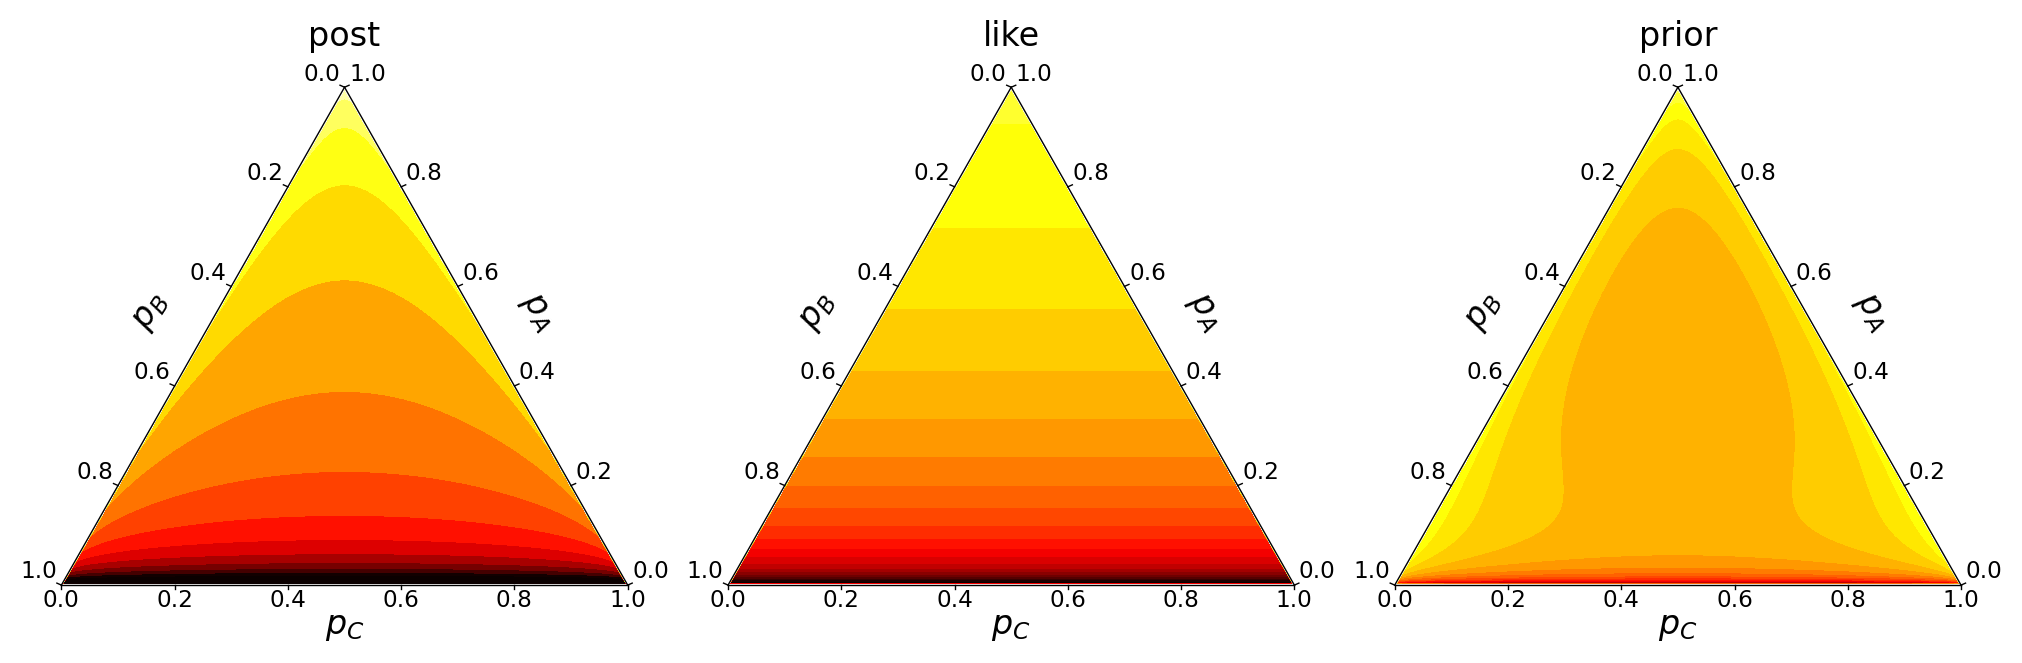

In [11]:
post = lambda p: dir_gauss_logpdf(p, 0.01, True)
like = lambda p: categ_logpdf(p)/0.32
prior = lambda p: post(p) - like(p)

log_pdf_fns = (
    (post, 'post'),
    (like, 'like'),
    (prior, 'prior'),
)

fig, axs = plt.subplots(1, len(log_pdf_fns), figsize=[10, 3.2], layout='compressed')
for ax, (log_pdf_fn, name) in zip(axs.flatten(), log_pdf_fns):
    ax.set_title(name)
    
    # plot pdf
    xy, p, valid = make_grid()
    pdf_valid = vmap(log_pdf_fn)(p[valid])
    pdf_valid -= jax.scipy.special.logsumexp(pdf_valid)
    img = jnp.zeros(valid.shape).at[valid].set(pdf_valid)
    ax.contourf(img.T, origin='lower', levels=40, extent=[0, 1, 0, 1], vmin=-25, vmax=-5, cmap='hot')
    plot_trinagle_axes(ax)

plt.show()

# cold vs warm likelihood

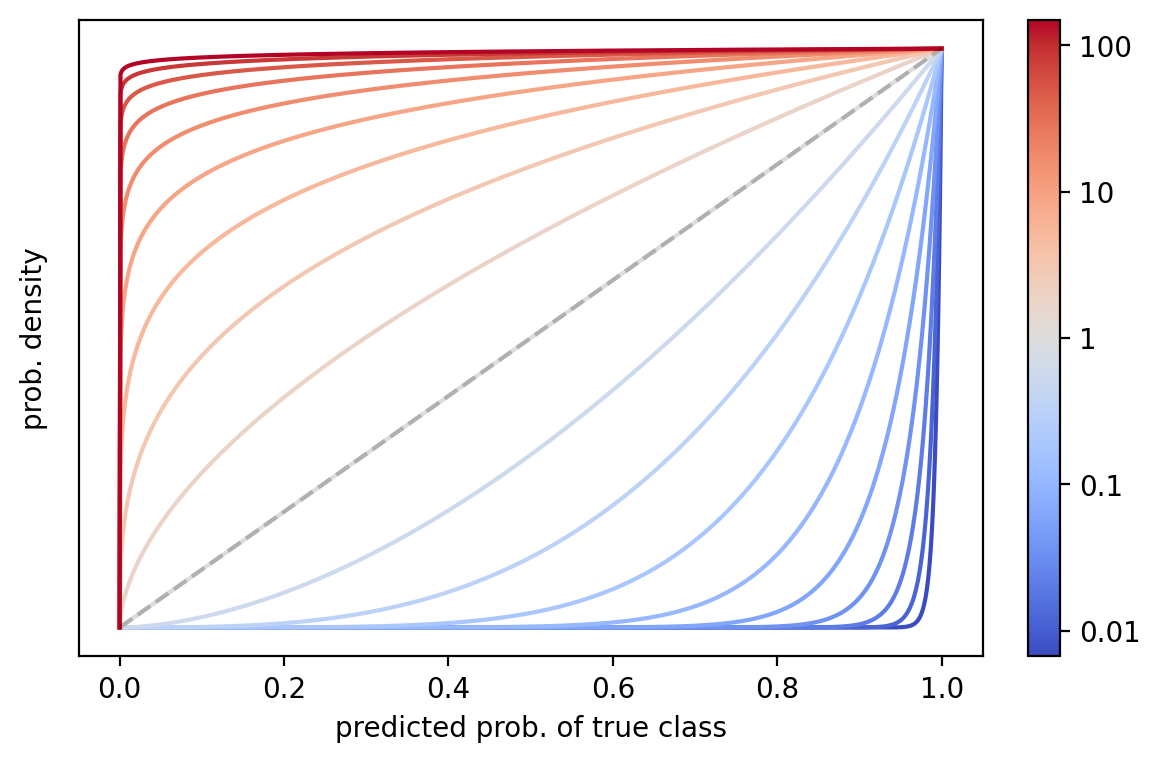

In [12]:
fig, ax = plt.subplots(figsize=(5.7, 3.7), layout='compressed')
pdf_categ_fn = lambda x, T=1: x**(1/T)
x = jnp.linspace(0, 1, 1_000)

temps = jnp.geomspace(1, 150, 10)
temps = jnp.concatenate([1/temps[::-1], temps[1:]])
color_mapper = mpl.cm.ScalarMappable(cmap='coolwarm')
colors = color_mapper.to_rgba(jnp.log(temps))
for T, c in zip(temps, colors):
    ax.plot(x, pdf_categ_fn(x, T=T), c=c)
ax.plot(x, pdf_categ_fn(x, T=1), c='black', ls='--', alpha=0.2)
    
ax.set_xlabel('predicted prob. of true class')
ax.set_ylabel('prob. density')
# ax.set_ylim((-0.1, 1.1))
ax.set(yticklabels=[])
ax.tick_params(left=False)
# ax.legend(loc='upper left')
cbar = fig.colorbar(color_mapper, ax=ax, format=lambda x, _: f'{remove_zeros(jnp.exp(x))}')
cbar.set_ticks(jnp.log(jnp.array([0.01, 0.1, 1, 10, 100])))

plt.savefig('../plots/tempered_likelihood.pdf')
plt.show()

# temp and lr schedule

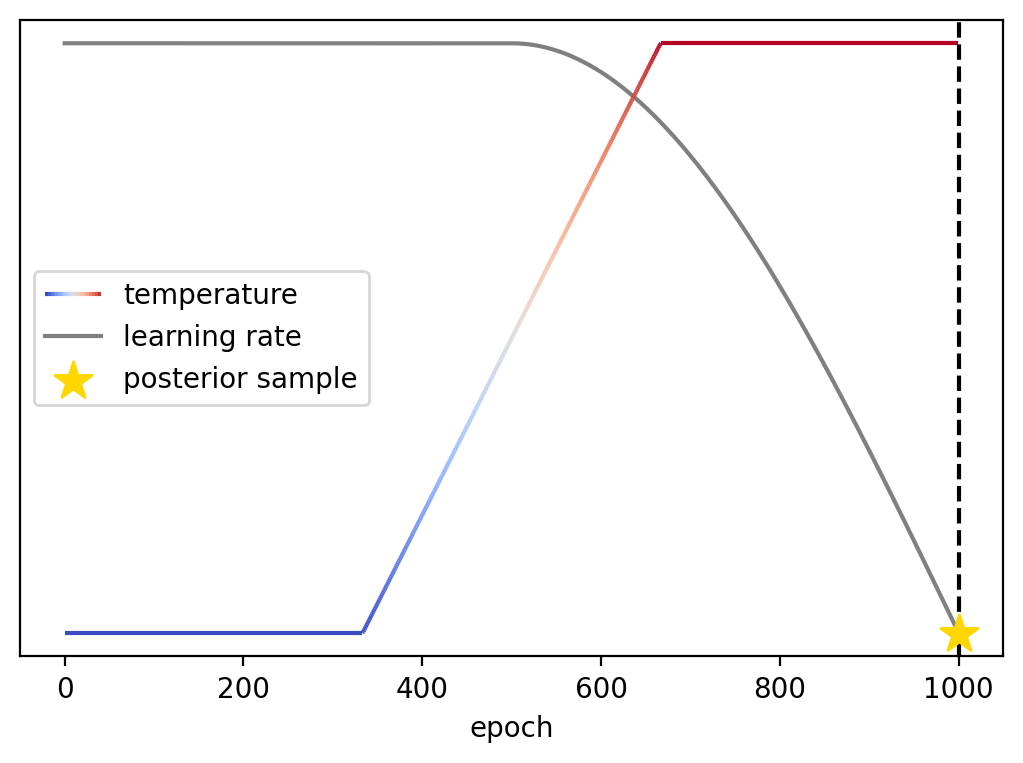

In [13]:
fig, ax = plt.subplots(figsize=(5, 3.7), layout='compressed')

# plot lr
n_epochs = 1_000
epoch = jnp.arange(n_epochs)
lr = jnp.where(epoch < n_epochs/2, 1, jnp.sin(jnp.pi*(epoch/n_epochs)))
ax.plot(epoch, lr, c='gray', label='learning rate')

# plot temp
T = jnp.clip(3*(epoch/n_epochs) - 1, 0, 1)
points = jnp.stack([epoch, T], 1)
segments = jnp.stack([points[:-1], points[1:]], axis=1)
lc = mpl.collections.LineCollection(segments, cmap='coolwarm', norm=plt.Normalize(0, 1))
lc.set_array(T)
ax.add_collection(lc)

# star
ax.scatter([n_epochs], [-0.002], color='gold', marker='*', s=200, zorder=5, clip_on=False, label='posterior sample')
ax.axvline(n_epochs, color='black', ls='--')

# legend
def make_gradient_line(x0, y0, w, h, n_rectangles=50):
    colors = mpl.cm.coolwarm(np.linspace(0, 1, n_rectangles))
    x = np.linspace(x0, x0+w, n_rectangles)
    y = np.repeat((y0 + h/2), n_rectangles)
    points = jnp.stack([x, y], 1)
    segments = jnp.stack([points[:-1], points[1:]], axis=1)
    line_collection = mpl.collections.LineCollection(segments, edgecolors=colors)
    return line_collection
class GradientLegendHandler:
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        w, h = handlebox.width, handlebox.height
        line_collection = make_gradient_line(x0, y0, w, h, 20)
        handlebox.add_artist(line_collection)
        return line_collection
handles, labels = ax.get_legend_handles_labels()
handles = (mpl.lines.Line2D([0], [0], label='temperature'), *handles)
ax.legend(loc='center left', handles=handles, handler_map={handles[0]: GradientLegendHandler()})

ax.set_ylim((-0.04, 1.04))
ax.set_xlabel('epoch')
ax.set(yticklabels=[])
ax.tick_params(left=False)
plt.savefig('../plots/sghmc_schedule.pdf')
plt.show()

# Dirichlet Gaussian visualization

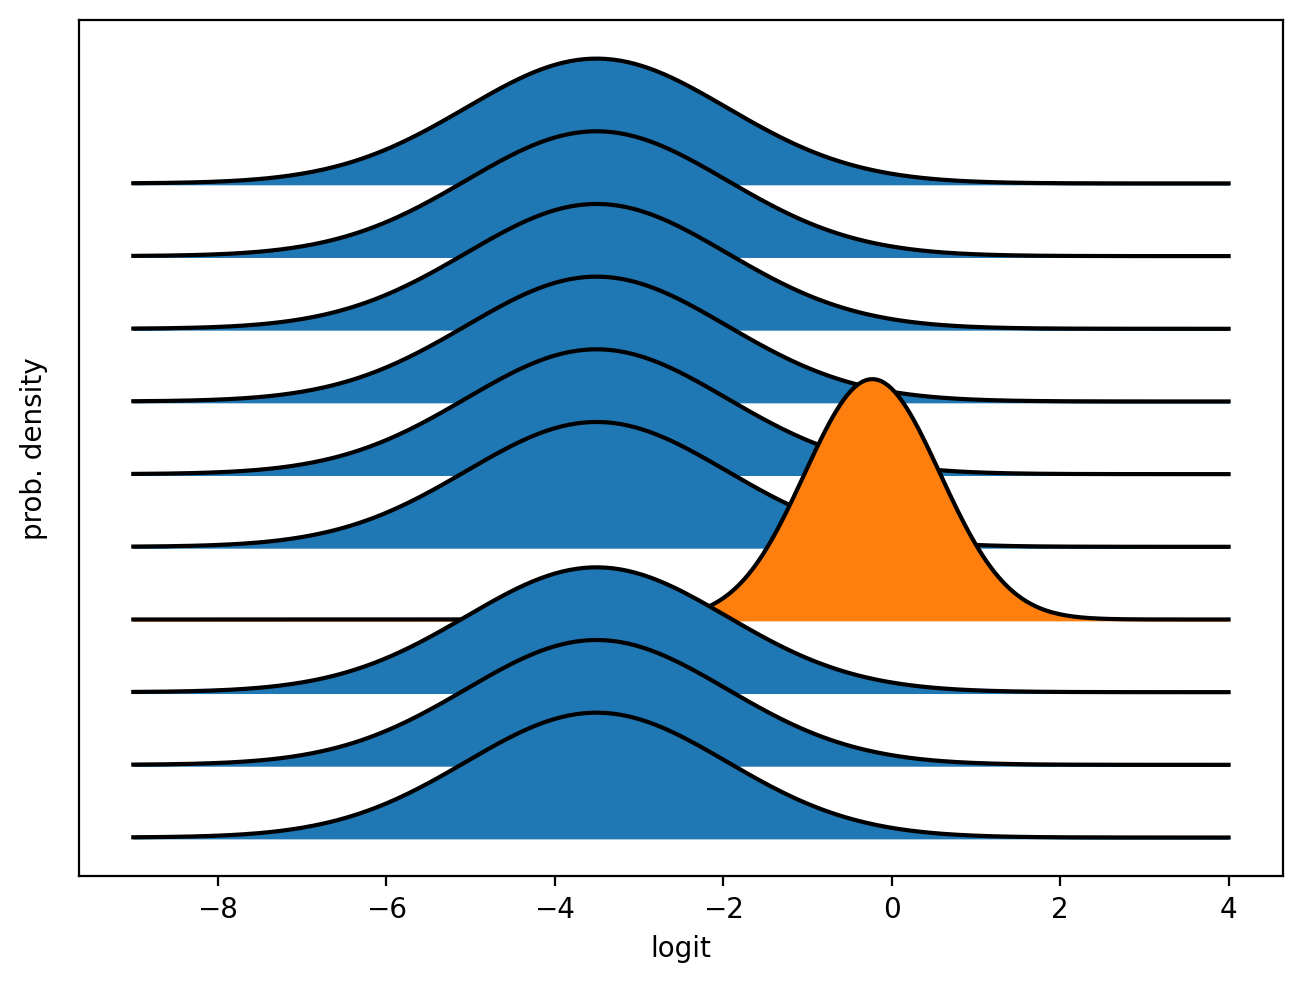

In [14]:
# ridgeline plot of Dirichlet Gaussian
fig, ax = plt.subplots(layout='compressed')

n_class = 10
label = 3
alpha = (0.1 * jnp.ones(n_class)).at[label].add(1)
var = jnp.log(1 / alpha + 1)
mean = jnp.log(alpha) - var / 2
overlap = 0.85 # overlap between distributions, range [0, 1]
n_points = 300
x = np.linspace(-9, 4, n_points)
for i in range(n_class):
    y0 = i * (1-overlap) * np.ones(n_points)
    y = jax.scipy.stats.norm.pdf(x, mean[i], jnp.sqrt(var[i]))
    color = 'C1' if i == label else 'C0'
    ax.fill_between(x, y0, y0+y, zorder=-i, color=color)
    ax.plot(x, y0+y, c='black', zorder=-i)

ax.set(yticklabels=[])
ax.tick_params(left=False)
ax.set_xlabel('logit')
ax.set_ylabel('prob. density')
plt.show()